In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [ ]:
# Provide paths to the base dataset and forecast result (zarr files)
base_path = ""
paradis_path = ""

# Input the paths associated with the forecasts/reference datasets in weatherbench format
ds_paradis = xr.open_mfdataset(paradis_path, engine="zarr")
ds_base = xr.open_mfdataset(base_path, engine="zarr")

# Make sure dataset is appropriately sorted and remove possible precision errors in latitude/longitudes
ds_base = ds_base.sortby("time")
ds_paradis = ds_paradis.sortby("time")

ds_paradis = ds_paradis.assign_coords(
    latitude=np.round(ds_paradis.latitude, 6),
    longitude=np.round(ds_paradis.longitude, 6)
)

ds_base = ds_base.assign_coords(
    latitude=np.round(ds_base.latitude, 6),
    longitude=np.round(ds_base.longitude, 6)
)

# For PARADIS, consider the first 6h (prediction_timedelta=0)
ds_paradis = ds_paradis.isel(
    prediction_timedelta=0
)

# Readjust time to match that of base dataset
ds_paradis["time"] = ds_paradis.time + ds_paradis.prediction_timedelta

lat = ds_paradis.latitude
lon = ds_paradis.longitude

ds_base = ds_base.sel(latitude=lat, longitude=lon)

# Extract the appropriate time instances from the base
ds_base = ds_base.sel(time=ds_paradis.time)

# Clean up array (optional)
ds_paradis = ds_paradis.drop_vars("prediction_timedelta")
ds_paradis = ds_paradis.reindex_like(ds_base)

# Pre-compute integration weights
cosine_weight = np.cos(lat * np.pi / 180)
cosine_weight = cosine_weight / cosine_weight.sum()

# Get the latitude and longitude grid
longitude, latitude = np.meshgrid(lon, lat)

# Get a simple pointwise error for GZ500
diff_paradis = ds_base.sel(level=500).geopotential - ds_paradis.sel(level=500).geopotential

sd500 = (diff_paradis / 9.80616) ** 2

error_paradis = (sd500.mean(dim="longitude") * cosine_weight).sum(dim="latitude")
mse_paradis = (error_paradis.mean(dim="time") ** 0.5).compute()

print("GZ500-RMSE-PARADIS", f"{mse_paradis:.2f}m")

GZ500-RMSE-PARADIS 1.77m


Visualize a field against the base dataset

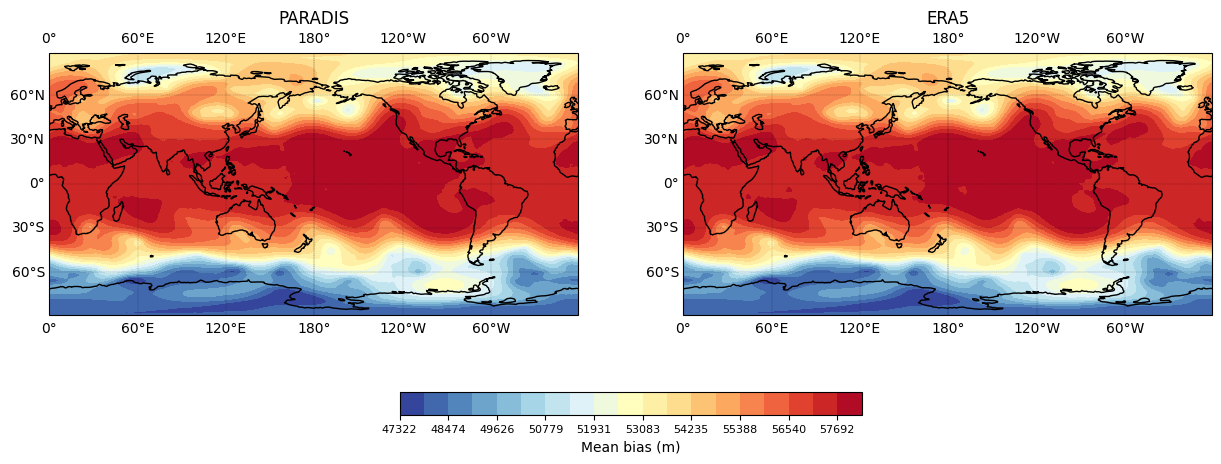

In [21]:
proj = ccrs.PlateCarree(central_longitude=180)

# Set up the figure with two subplots using a PlateCarree projection.
fig, ax = plt.subplots(
    ncols=2, figsize=(15, 5), subplot_kw={"projection": proj}, sharex=True, sharey=True
)

# Create smooth contour plots using contourf.
z_base = ds_base.isel(time=0).sel(level=500).geopotential.compute()
z_paradis = ds_paradis.isel(time=0).sel(level=500).geopotential.compute()

vmax = float(np.max([np.max(z_base), np.max(z_paradis)]))
vmin = float(np.min([np.min(z_base), np.max(z_paradis)]))

levels = np.linspace(vmin, vmax, 20)
im0 = ax[0].contourf(
    longitude,
    latitude,
    z_paradis,
    cmap="RdYlBu_r",
    transform=ccrs.PlateCarree(),
    levels=levels,
)

im2 = ax[1].contourf(
    longitude,
    latitude,
    z_base.T,
    cmap="RdYlBu_r",
    transform=ccrs.PlateCarree(),
    levels=levels,
)

# Add coastlines to overlay continent outlines.
ax[0].coastlines(resolution="110m", linewidth=1)
ax[1].coastlines(resolution="110m", linewidth=1)

# Add a shared horizontal colorbar below the subplots.
cbar = fig.colorbar(
    im0,
    ax=ax,
    orientation="horizontal",
    fraction=0.06,
    pad=0.2,
    label="Mean bias (m)",
    extend="max",
)
cbar.ax.tick_params(labelsize=8)

for a in ax:
    gl = a.gridlines(
        draw_labels=True, linewidth=0.25, color="black", alpha=0.5, linestyle="--"
    )

# Set titles for each subplot.
ax[0].set_title("PARADIS")
ax[1].set_title("ERA5")

# Adjust layout to reserve space at the bottom for the colorbar.
plt.show()

Visualize RMSe distribution

In [ ]:
# Get the RMSe distribution
mse_plot_paradis = (sd500.mean(dim="time") ** 0.5).compute()

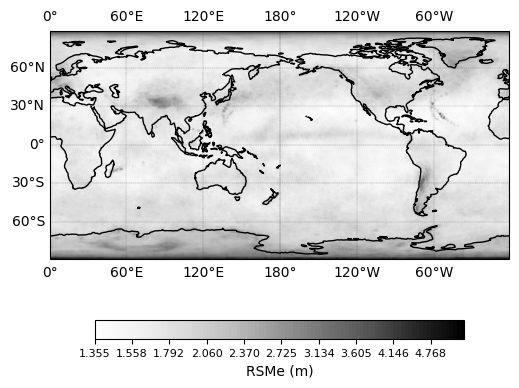

In [19]:
from matplotlib.colors import LogNorm
from matplotlib.ticker import ScalarFormatter

proj = ccrs.PlateCarree(central_longitude=180)

# Set up the figure with two subplots using a PlateCarree projection.
fig, ax = plt.subplots(
    ncols=1, figsize=(12, 4), subplot_kw={"projection": proj}, sharex=True, sharey=True
)

z_paradis = mse_plot_paradis

vmax = np.max([z_paradis])
vmin = np.min([z_paradis])

levels = np.logspace(np.log10(vmin), np.log10(vmax), 100)
norm = LogNorm(vmin=vmin, vmax=vmax)

im0 = ax.contourf(
    longitude,
    latitude,
    z_paradis.T,
    cmap="Grays",
    transform=ccrs.PlateCarree(),
    levels=levels,
    norm=norm,
)

# Add coastlines to overlay continent outlines.
ax.coastlines(resolution="110m", linewidth=1)

# Add a shared horizontal colorbar below the subplots.
cbar = fig.colorbar(
    im0,
    ax=ax,
    orientation="horizontal",
    fraction=0.06,
    pad=0.2,
    label="RSMe (m)",
    extend="max",
)

# Keep colorbar ticks in scalar format
cbar.formatter = ScalarFormatter(useMathText=False)
cbar.update_ticks()
cbar.ax.tick_params(labelsize=8)

# Add geography
gl = ax.gridlines(
    draw_labels=True, linewidth=0.25, color="black", alpha=0.5, linestyle="--"
)

# Adjust layout to reserve space at the bottom for the colorbar.
plt.show()